# Naive Bayes Classification

Naive Bayes models are a group of extremely fast and simple classiciation algorithms that are often suitable for high-dimensional datasets. Because they are so fast and have so few tunable parameters, they are useful as a quick-and-dirty baseline for a classification problem.

In Bayesian classification, we're interested in finding the probability of a label given some observed features. As a generative model, Naive Bayes specifies the hypothetical random process that generates the data. The "naive" in Naive Bayes comes from the fact that naive assumptions are made about the generative model for each label.

Benefits of Bayes Classifiers:
- Fast for training and prediction
- Straightforward probabilistic prediction
- Easily interprettable
- Few, if any, tuning parameters

Naive Bayes Classifiers:
- Gaussian
- Multinomial
- Bernoulli

Here I choose a Gaussian Naive Bayes Classifier because our model features are continuous.

## Init Env and Load Data

In [7]:
# load libraries

# load data and visualization
import numpy as np
import pandas as pd
import seaborn as sns

# machine learning
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Lasso
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix


In [43]:
# load data from csv
train_data = pd.read_csv('data/train_data_fe.csv')
print(train_data.shape)
test_data = pd.read_csv('data/test_data_fe.csv')
print(test_data.shape)

(62889, 47)
(15723, 47)


In [44]:
# features
print(train_data.columns)

Index(['id', 'img_id', 'da', 'dp', 'fwidth', 'flength', 'fthickness',
       'elength', 'ethickness', 'ewidth', 'volume', 'area', 'perimeter',
       'chull_area', 'chull_perimeter', 'sphericity', 'l_t_ratio',
       't_l_aspect_ratio', 'compactness', 'roundness', 'ellipse_ratio',
       'circularity', 'solidity', 'concavity', 'convexity', 'extent', 'hash',
       'transparency', 'curvature', 'surface_area', 'l_w_ratio', 'w_l_ratio',
       'w_t_ratio', 't_w_ratio', 'chull_surface_area', 'sieve', 'angularity',
       'ellipticity', 'fiber_length', 'fiber_width', 'krumbein_rnd',
       'stone_soil', 'thick_vol_prod', 'thick_perm_prod', 'thick_trans_prod',
       'rnd_ell_prod', 'stone_soil_enc'],
      dtype='object')


In [45]:
# drop unneeded columns
train_data.drop(['id','img_id','hash','stone_soil'], axis = 1, inplace = True)
test_data.drop(['id','img_id','hash','stone_soil'], axis = 1, inplace = True)


In [46]:
# format
X_train = train_data.drop('stone_soil_enc', axis = 1)
y_train = train_data['stone_soil_enc']
X_test = test_data.drop('stone_soil_enc', axis = 1)
y_test = test_data['stone_soil_enc']

## Model 1

In [51]:
# fit model
classifier = GaussianNB()
model_1 = classifier.fit(X_train, y_train)

In [52]:
# cross-validation with f1 metric
model_score = cross_val_score(model_1, X_train, y_train, scoring = "f1")
print(model_score)
print(model_score.mean())

[0.13268608 0.14003295 0.13712375 0.14262561 0.14238953]
0.13897158240775603


## Model 2
- Select important features

### Feature Selection

In [53]:
## recursive feature elimination via lasso regression
model_rfe = RFECV(Lasso(alpha = 0.0001), cv = 5)
model_rfe.fit(X_train, y_train)

RFECV(cv=5, estimator=Lasso(alpha=0.0001))

In [54]:
# feature ranking
rfe = model_rfe.ranking_
features = X_train.columns
rfe_df = pd.DataFrame({'features': features, 'rfe_rank': rfe})
rfe_df.sort_values(by = 'rfe_rank', ascending = True)

,features,rfe_rank
0,da,1
36,fiber_width,1
34,ellipticity,1
33,angularity,1
30,t_w_ratio,1
29,w_t_ratio,1
28,w_l_ratio,1
25,curvature,1
24,transparency,1
19,circularity,1


In [55]:
# features ranked 1 are the most important
# select only the more important features as a means of regularization
selected_features = rfe_df[rfe_df['rfe_rank'] == 1]['features'].values
X_train_new = X_train[selected_features]
X_test_new = X_test[selected_features]

### Fit Model

In [56]:
# fit model
classifier = GaussianNB()
model_2 = classifier.fit(X_train_new, y_train)

In [57]:
# cross-validation with f1 metric
model_score = cross_val_score(model_2, X_train_new, y_train, scoring = "f1")
print(model_score)
print(model_score.mean())

[0.17657446 0.16909621 0.1783591  0.17751479 0.18288394]
0.17688569874532784


## Test
- Test selected model

In [59]:
# predict on test
pred = model_2.predict(X_test_new)

In [60]:
# scores
print(accuracy_score(y_test, pred))
print(precision_score(y_test, pred))
print(recall_score(y_test, pred))
print(f1_score(y_test, pred))

0.86949055523755
0.13836948391922213
0.17050691244239632
0.152766308835673


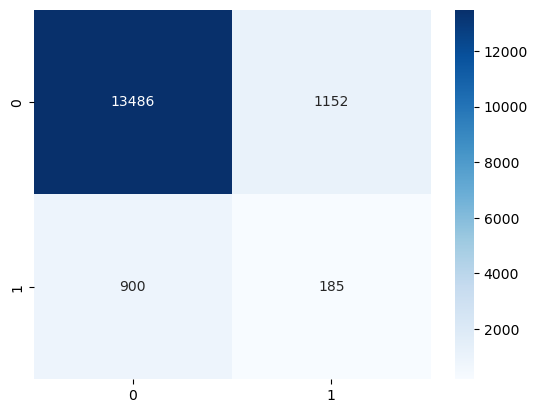

In [61]:
conf = confusion_matrix(y_test, pred)
sns.heatmap(conf, annot=True, fmt = 'g', cmap = "Blues");